1. Installing required dependencies

1.1. Using GPU for Training

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [2]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import pandas as pd
import re
# import emoji

# Load the dataset into a pandas dataframe.
df_true = pd.read_csv('True.csv',encoding='UTF-8')
df_fake = pd.read_csv('Fake.csv',encoding='UTF-8')

# creating target variable
df_true['target'] = 1
df_fake['target'] = 0

# concatenating in one single dataframe
train_df = df_true.append(df_fake)
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 44,898



,title,text,subject,date,target
28225,[VIDEO] YEP…GUN-CONTROL BILL SAID THAT TODAY: ...,You can t have people walking around with gun...,left-news,"Jun 14, 2015",0
31872,EU warns U.S. it may respond swiftly to counte...,BRUSSELS (Reuters) - The European Union warned...,politicsNews,"July 26, 2017",1
31947,MARINE CORPS GENERAL WARNS U.S. TROOPS: “There...,While the mainstream media remains transfixed ...,politics,"Dec 23, 2017",0
6712,Tax overhaul drama moves to Senate as House ap...,WASHINGTON (Reuters) - Congressional Republica...,politicsNews,"November 16, 2017",1
14413,SUNDAY SCREENING: The Deep State: Hiding in Pl...,Our weekly documentary screening curated by th...,Middle-east,"September 3, 2017",0
11434,THE TEA PARTY IS MAKING A COMEBACK! Conservati...,As liberal protesters step up confrontations w...,politics,"Feb 16, 2017",0
4041,Thousands of Indonesians join anti-Myanmar ral...,"JAKARTA (Reuters) - Thousands of Indonesians, ...",worldnews,"September 6, 2017",1
36863,McCain Has The Best Laugh He’s Had In 80 Year...,It s gotta be hard these days to be John McCai...,News,"October 30, 2017",0
18491,POLL: Most Trump Supporters Say Fake ‘Bowling...,Did you know that people who support Donald Tr...,News,"February 10, 2017",0
24290,Supreme Court faces 4-4 split in Obamacare con...,WASHINGTON (Reuters) - The Supreme Court on We...,politicsNews,"March 23, 2016",1


In [4]:
# Get the lists of sentences and labels
sentences = train_df['title'].values
labels = train_df['target'].values
train_df['title'][10]

'Cambodia deports 61 telecom extortion scam suspects'

In [5]:
# loading pre-trained models
from transformers import (
    BertForSequenceClassification,
#     TFBertForSequenceClassification, 
                          BertTokenizer,
#                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                         AdamW)

# BERT
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                                num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                # You can increase this for multi-class tasks.   
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tell pytorch to run this model on the GPU.
bert_model.cuda()
                                                           

# RoBERTa
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' Base models loaded')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

 Base models loaded


In [6]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the tweet split into tokens.
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))

# Print the tweet mapped to token ids.
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))

# Print the tweet split into tokens.
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(sentences[0]))

# Print the tweet mapped to token ids.
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))

 Original:   BUSTED: Trump Running Mate Mike Pence Caught Suppressing Up To 10,000 Black Votes
Tokenized BERT:  ['busted', ':', 'trump', 'running', 'mate', 'mike', 'pen', '##ce', 'caught', 'suppress', '##ing', 'up', 'to', '10', ',', '000', 'black', 'votes']
Token IDs BERT:  [23142, 1024, 8398, 2770, 6775, 3505, 7279, 3401, 3236, 16081, 2075, 2039, 2000, 2184, 1010, 2199, 2304, 4494]
Tokenized RoBERT:  ['ĠB', 'UST', 'ED', ':', 'ĠTrump', 'ĠRunning', 'ĠMate', 'ĠMike', 'ĠPence', 'ĠC', 'aught', 'ĠSupp', 'ressing', 'ĠUp', 'ĠTo', 'Ġ10', ',', '000', 'ĠBlack', 'ĠVotes']
Token IDs RoBERTa:  [163, 11120, 1691, 35, 140, 15552, 12869, 1483, 6913, 230, 19906, 13256, 9828, 3105, 598, 158, 6, 151, 1378, 39347]


In [7]:
sequence = """Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️"""

bert_tokenized_sequence = bert_tokenizer.tokenize(sequence)
roberta_tokenized_sequence = roberta_tokenizer.tokenize(sequence)

print("""Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️""")
print("BERT:", bert_tokenized_sequence)
print("RoBERTa:", roberta_tokenized_sequence)

Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️
BERT: ['will', 'your', 'hometown', 'be', 'taking', 'in', 'obama', '’', 's', 'refugees', '?', 'here', '’', 's', 'the', 'list', 'of', 'cities', 'where', 'they', '’', 're', 'being', 'transplant', '##ed', '[UNK]']
RoBERTa: ['Will', 'ĠYour', 'ĠH', 'ometown', 'ĠBe', 'ĠTaking', 'ĠIn', 'ĠObama', 'âĢ', 'Ļ', 's', 'ĠRefugees', '?', 'ĠHere', 'âĢ', 'Ļ', 's', 'ĠThe', 'ĠList', 'ĠOf', 'ĠCities', 'ĠWhere', 'ĠThey', 'âĢ', 'Ļ', 're', 'ĠBeing', 'ĠTrans', 'pl', 'anted', 'ĠðŁ', 'ı', 'Ļ', 'ï¸ı']


In [8]:
max_len_bert = 0
max_len_roberta = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))

    
print('Max sentence length BERT: ', max_len_bert)
print('Max sentence length RoBERTa: ', max_len_roberta)

Max sentence length BERT:  63
Max sentence length RoBERTa:  83


In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs BERT:', bert_input_ids[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Tommy\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitely activated but `max_length` is provided a specific value, please

Original:  WOW! BARBARA BUSH Will Be Keynote Speaker For Baby-Killing Planned Parenthood Fundraiser
Token IDs BERT: tensor([  101, 10166,   999,  6437,  5747,  2097,  2022, 25569,  5882,  2005,
         3336,  1011,  4288,  3740,  6687,  9021, 28536,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [10]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)
roberta_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

In [11]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]
# yes we were able to remove the sentence id from the data without disturbing the data format

(tensor([  101, 23142,  1024,  8398,  2770,  6775,  3505,  7279,  3401,  3236,
         16081,  2075,  2039,  2000,  2184,  1010,  2199,  2304,  4494,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

40,408 training samples
19,230 training samples with real disater tweets
4,490 validation samples
2,187 validation samples with real disater tweets


In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [14]:
# Get all of the roberta_model's parameters as a list of tuples.
params = list(roberta_model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [16]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [17]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

BERT Training

In [19]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
bert_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the bert_model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-bert_model-train-do-in-pytorch)
    bert_model.train()

    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        bert_model.zero_grad()        

        # Perform a forward pass (evaluate the bert_model on this training batch).
        # The documentation for this `bert_model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/bert_model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the bert_model
        # outputs prior to activation.
        loss, logits = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The bert_optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        bert_optimizer.step()

        # Update the learning rate.
        bert_scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(bert_train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the bert_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the bert_model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,263.    Elapsed: 0:00:09.
  Batch    80  of  1,263.    Elapsed: 0:00:17.
  Batch   120  of  1,263.    Elapsed: 0:00:26.
  Batch   160  of  1,263.    Elapsed: 0:00:35.
  Batch   200  of  1,263.    Elapsed: 0:00:43.
  Batch   240  of  1,263.    Elapsed: 0:00:51.
  Batch   280  of  1,263.    Elapsed: 0:00:59.
  Batch   320  of  1,263.    Elapsed: 0:01:07.
  Batch   360  of  1,263.    Elapsed: 0:01:15.
  Batch   400  of  1,263.    Elapsed: 0:01:23.
  Batch   440  of  1,263.    Elapsed: 0:01:31.
  Batch   480  of  1,263.    Elapsed: 0:01:39.
  Batch   520  of  1,263.    Elapsed: 0:01:47.
  Batch   560  of  1,263.    Elapsed: 0:01:55.
  Batch   600  of  1,263.    Elapsed: 0:02:03.
  Batch   640  of  1,263.    Elapsed: 0:02:11.
  Batch   680  of  1,263.    Elapsed: 0:02:19.
  Batch   720  of  1,263.    Elapsed: 0:02:27.
  Batch   760  of  1,263.    Elapsed: 0:02:35.
  Batch   800  of  1,263.    Elapsed: 0:02:43.
  Batch   840  of

RoBERTa Training

In [20]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
roberta_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the roberta_model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-roberta_model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the roberta_model on this training batch).
        # The documentation for this `roberta_model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/roberta_model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the roberta_model
        # outputs prior to activation.
        loss, logits = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The roberta_optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        roberta_optimizer.step()

        # Update the learning rate.
        roberta_scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(roberta_train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the roberta_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the roberta_model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
#                                    token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(roberta_validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    roberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,263.    Elapsed: 0:00:10.
  Batch    80  of  1,263.    Elapsed: 0:00:21.
  Batch   120  of  1,263.    Elapsed: 0:00:31.
  Batch   160  of  1,263.    Elapsed: 0:00:41.
  Batch   200  of  1,263.    Elapsed: 0:00:52.
  Batch   240  of  1,263.    Elapsed: 0:01:02.
  Batch   280  of  1,263.    Elapsed: 0:01:11.
  Batch   320  of  1,263.    Elapsed: 0:01:22.
  Batch   360  of  1,263.    Elapsed: 0:01:31.
  Batch   400  of  1,263.    Elapsed: 0:01:40.
  Batch   440  of  1,263.    Elapsed: 0:01:48.
  Batch   480  of  1,263.    Elapsed: 0:01:57.
  Batch   520  of  1,263.    Elapsed: 0:02:06.
  Batch   560  of  1,263.    Elapsed: 0:02:16.
  Batch   600  of  1,263.    Elapsed: 0:02:26.
  Batch   640  of  1,263.    Elapsed: 0:02:37.
  Batch   680  of  1,263.    Elapsed: 0:02:47.
  Batch   720  of  1,263.    Elapsed: 0:02:57.
  Batch   760  of  1,263.    Elapsed: 0:03:07.
  Batch   800  of  1,263.    Elapsed: 0:03:16.
  Batch   840  of

9. Evalution

In [21]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=roberta_training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.40e-02,7.32e-03,1.0,0:05:06,0:00:10
2,3.04e-03,2.63e-03,1.0,0:04:22,0:00:09


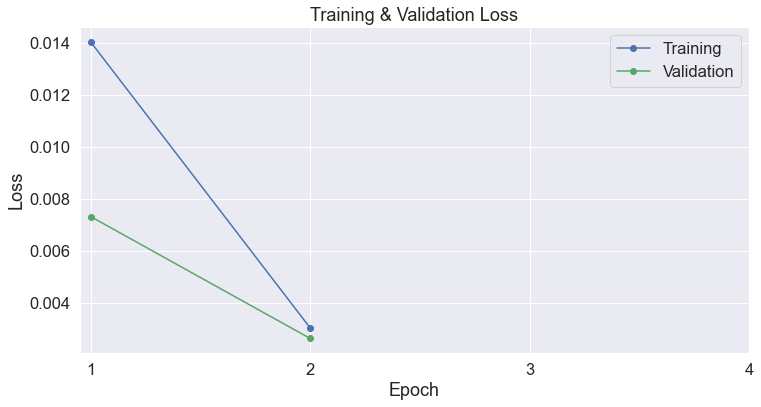

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

10. Detalied Evaluation on Test data

In [23]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df  = train_df.iloc[sentence_ids_list_valid,]

In [39]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.title.values
labels = df.target.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 75,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        #padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,490



In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,490 test sentences...
    DONE.


In [26]:
print('Positive samples: %d of %d (%.2f%%)' % (df.target.sum(), len(df.target), (df.target.sum() / len(df.target) * 100.0)))

Positive samples: 2187 of 4490 (48.71%)


In [27]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


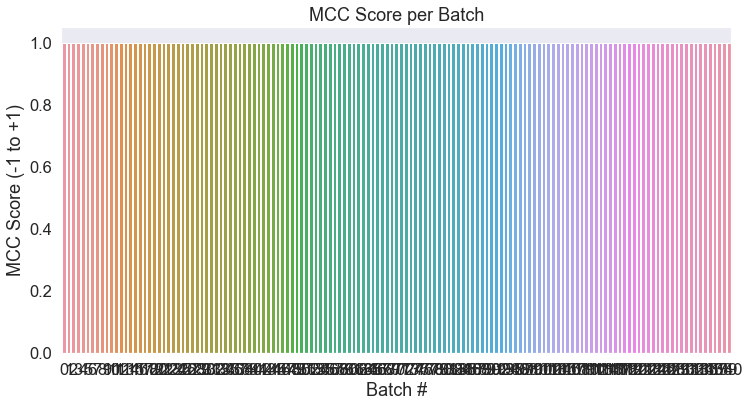

In [28]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [29]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# adding to the main datframe
df['target'] = flat_predictions

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
get_eval_report(flat_true_labels, flat_predictions)
# print('Total MCC: %.3f' % mcc)

<ipython-input-29-faa1cab02f22>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = flat_predictions


{'mcc': 1.0, 'tp': 2187, 'tn': 2303, 'fp': 0, 'fn': 0}

In [30]:
# import torch
# import numpy as np
# import pickle

# from sklearn.metrics import matthews_corrcoef, confusion_matrix

# from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
#                               TensorDataset)
# from torch.utils.data.distributed import DistributedSampler
# from torch.nn import CrossEntropyLoss, MSELoss

# from tools import *
# from multiprocessing import Pool, cpu_count
# import convert_examples_to_features

# from tqdm import tqdm_notebook, trange
# import os
# from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
# from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

# # OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
# import logging
# logging.basicConfig(level=logging.INFO)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:


# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "data/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'yelp.tar.gz'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'yelp'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_reports/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"



In [41]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [45]:
bert_model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(bert_validation_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    # create eval loss and other metric required by the task
    if OUTPUT_MODE == "classification":
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    elif OUTPUT_MODE == "regression":
        loss_fct = MSELoss()
        tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)
result = compute_metrics(TASK_NAME, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

<ipython-input-45-cdc882c20574>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(bert_validation_dataloader, desc="Evaluating"):


ValueError: not enough values to unpack (expected 4, got 3)